# Introduction

This notebook aims to identify the parameters of the SEIR model develop by Magal & Webb with the behavourial dynamic illustrated in the blog post of John Cochrane "a behavourial SIR model" basically
$$
\begin{align*}
S'(t)  & =-\beta_t S(t) \frac{(I(t) + U(t))}{N}\\
I'(t)   & =\beta_t S(t)\frac{(I(t) + U(t))}{N}-\nu I(t)\\
R'(t)   & = \nu_1 I(t) - \eta R(t) \\
U'(t)  &= \nu_2 I(t) - \eta U(t)
\end{align*}
$$
with $S$ the suceptible, $I$ the infectious, $R$ the reported symptomatic infectious, $U$ the unreported infectious. 
We consider that $\beta_t$ evolves with the dynamic of the reported infectious such that
$$
\log(\beta_t) = \log(\beta_0) - \alpha  \frac{R(t)}{N} \ ,
$$
This evolution could as well model a policy response or a sum of individual responses fueled by the fear of catch the disease. That's why the model is coined as a behavourial SEIR. 
We also have the 

# The model

In [120]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
from scipy.integrate import odeint
%matplotlib inline

In [141]:
# the behavourial SIR model

def behavourial_seir_ode(y, *args):
   
    alpha, eta, beta_0, nu, f, N = args[1]
    nu1, nu2 = f*nu, (1-f)*nu
    beta_t = beta_0 * np.exp(- alpha * y[2]/N)
    
    ds = - beta_t * y[0] * (y[1] + y[3]) / N
    di = beta_t * y[0] * (y[1] + y[3]) / N - nu * y[1]
    dr = nu1 * y[1] - eta * y[2]
    du = nu2 * y[1] - eta * y[3]
    
    return np.array([ds, di, dr, du])

With $\alpha = 0$, the model above is the standard SIR model 

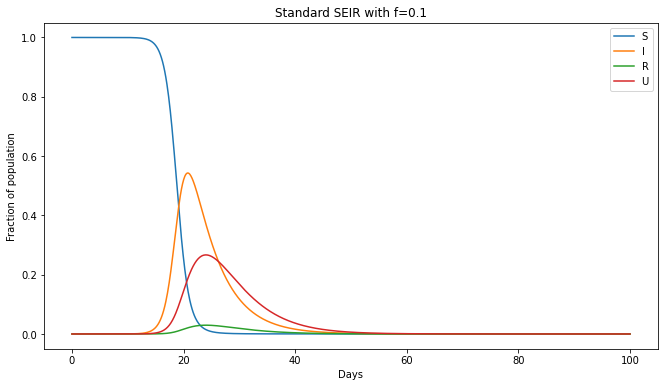

In [263]:
# Standard SEIR

t = np.linspace(0, 100, 1000)
y0 = [60e6, 1, 0, 0]
f = 0.1
N = 60e6
params = [0, 0.25, 1, 0.2, f, N]

sol = odeint(behavourial_seir_ode, y0, t, args=(params,))

plt.figure(figsize=(11, 6))
plt.plot(t, sol[:, 0]/N, label="S")
plt.plot(t, sol[:, 1]/N, label="I")
plt.plot(t, sol[:, 2]/N, label="R")
plt.plot(t, sol[:, 3]/N, label="U")
plt.legend(loc="best")
plt.title(f"Standard SEIR with f={f}")
plt.xlabel("Days")
plt.ylabel("Fraction of population")
plt.show()

The behavourial model is validated with the parameters of John Cochrane's blog post

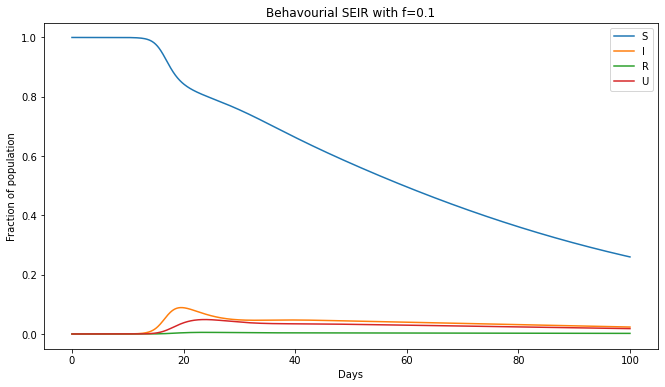

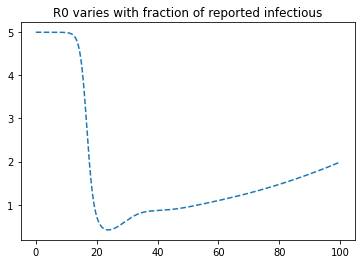

In [277]:
# Behavourial SEIR 

t = np.linspace(0, 100, 1000)
y0 = [60e6, 1, 0, 0]
f = 0.1
N = 60e6
params = [(0 - np.log(0.1))*1e4/50, 0.25, 1, 0.2, f, N]

sol = odeint(behavourial_seir_ode, y0, t, args=(params,))

plt.figure(figsize=(11, 6))
plt.plot(t, sol[:, 0]/N, label="S")
plt.plot(t, sol[:, 1]/N, label="I")
plt.plot(t, sol[:, 2]/N, label="R")
plt.plot(t, sol[:, 3]/N, label="U")
plt.legend(loc="best")
plt.title(f"Behavourial SEIR with f={f}")
plt.xlabel("Days")
plt.ylabel("Fraction of population")
plt.show()

plt.plot(t, params[2]/params[3] * np.exp(- params[0] * sol[:, 2]/N), '--')
plt.title("R0 varies with fraction of reported infectious")
plt.show()

The dynamic is way different from the standard SIR, as we see the $R0$ coefficient drops quickly below $1$ before the 30th day of the pandemic, but goes up avec the peak in the numbers of reported cases.  
The dynamic is also slower than the standard SIR, only $20\%$ of the population catch the disease after 100 days for $f=0.4$.

# Parameters fitting

The measured data correspond to $R(t)$, we consider that the the data $R_{measure}(t)$ are random variables with Poisson distribution (count data). Assuming a gaussian approximation, parameters are fitted using least squares rescaled with Poisson noise. The data used are french confirmed cases from the John Hopkins University github repository.

In [6]:
import pandas as pd
import requests

df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

filtered_df = df[df["Country/Region"] == "France" ]
filtered_df = filtered_df[df["Province/State"].isnull()]
confirmed = filtered_df.iloc[0, 6:].values

/home/clementgauchy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


In [7]:
confirmed

array([2, 3, 3, 3, 4, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 11, 11, 11, 11, 11,
       11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 14, 18, 38, 57,
       100, 130, 191, 204, 285, 377, 653, 949, 1126, 1209, 1784, 2281,
       2281, 3661, 4469, 4499, 6633, 7652, 9043, 10871, 12612, 14282,
       16018, 19856, 22304, 25233, 29155, 32964, 37575, 40174, 44550,
       52128, 56989, 59105, 64338, 68605, 70478, 74390, 78167, 82048,
       86334, 90676, 93790, 120633, 124298, 129257, 132473, 144944,
       146923, 146906, 151808, 154188, 156921, 154715, 157026, 158636,
       160292, 160847, 164589, 167605, 165093, 165764, 165764, 166976,
       167272, 167886, 168935, 172465, 173040, 174318], dtype=object)

In [284]:
from scipy.optimize import minimize, basinhopping
y0 = [60e6, 1, 0, 0]
N = 60e6
f = 0.4

def least_squares(params, *args):
    data = args[0]
    T = len(data)
    new_params = np.zeros(6)
    new_params[:4] = params
    new_params[4:] = [f, N]
    t = np.linspace(0, T, int(5*(T-1)))
    res = odeint(behavourial_seir_ode, y0, t, args=(new_params,))
    loss = 0
    for i in np.arange(int(5*T - 6)):
        if i % 5 == 0:
            loss += (data[i // 5] - res[i, 2])**2 / data[i // 5]
    return loss/T

params_init = [0, 0.77, 1, 0.2]

# "realistic" bounds for the different parameters
bnds = ([0, None], [0.001, 1.5], [0.15, 3], [0.001, 0])

# deterministic L-BFGS-B search to find at least a local optimum
params_star = minimize(least_squares, params_init, args=(confirmed), bounds=bnds, method="L-BFGS-B")
params_star

#minimizer_kwargs = {"method": "L-BFGS-B", "bounds":bnds, "args": confirmed}
#ret = basinhopping(loglik, params_init, minimizer_kwargs=minimizer_kwargs, niter=200)
#ret

      fun: 287.5970294338264
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.86725343e-02,  7.30757910e+02, -5.08264520e+02,  1.42182955e+01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1060
      nit: 143
   status: 0
  success: True
        x: array([5.66540680e+02, 3.07866235e-02, 3.10953717e-01, 1.00000000e+00])

Text(0.5, 1.0, 'Model versus data visualisation')

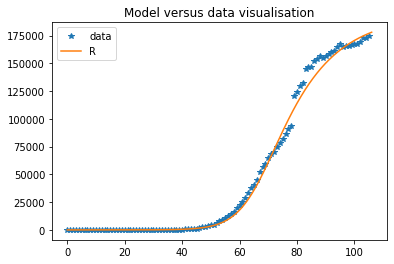

In [285]:
# Validation of the fitting step

T = len(confirmed)
t = np.linspace(0, T, int(5*T + 1))

y0 = [60e6, 1, 0, 0]
N = 60e6
params = np.array(list(params_star.x) + [f, N])

sol = odeint(behavourial_seir_ode, y0, t, args=(params,))

plt.plot(range(T), confirmed, '*', label="data")
plt.plot(t, sol[:, 2], label="R")
plt.legend(loc="best")
plt.title("Model versus data visualisation")

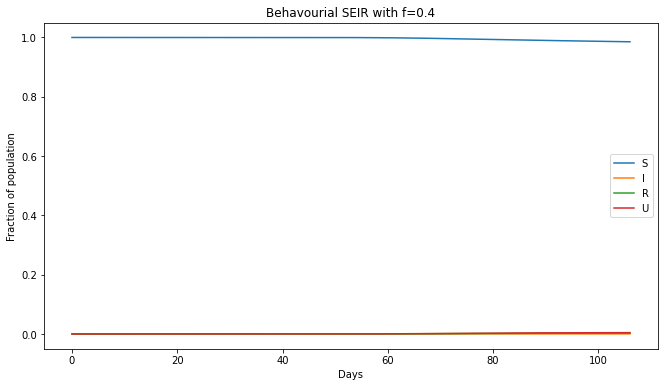

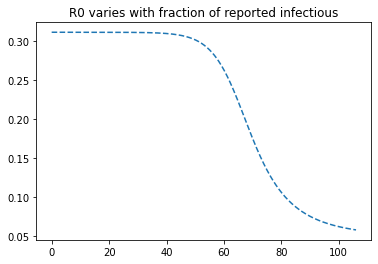

In [286]:
# Prediction with the behavourial SEIR model

plt.figure(figsize=(11, 6))
plt.plot(t, sol[:, 0]/N, label="S")
plt.plot(t, sol[:, 1]/N, label="I")
plt.plot(t, sol[:, 2]/N, label="R")
plt.plot(t, sol[:, 3]/N, label="U")
plt.legend(loc="best")
plt.title(f"Behavourial SEIR with f={f}")
plt.xlabel("Days")
plt.ylabel("Fraction of population")
plt.show()

plt.plot(t, params[2]/params[3] * np.exp(- params[0] * sol[:, 2]/N), '--')
plt.title("R0 varies with fraction of reported infectious")
plt.show()

# Uncertainty quantification
## Sobol index
First, we study the Sobol index of the parameters $\alpha, \, \beta_0, \eta, \nu, f$ on the attack rate after 100 days. We suppose that each parameters follows an uniform distribution on its support.

In [250]:
support = ([0, 400], [0.01, 1.5], [0.15, 3], [0.001, 1], [1e-3, 1])

n = int(1000)
sample = sps.uniform.rvs(size=(n, 5))
for i in range(5):
    loc = support[i][0]
    scale = support[i][1] - support[i][0]
    sample[:, i] = loc + scale * sample[:, i]

sample_i = sps.uniform.rvs(size=(n, 5))
for i in range(5):
    loc = support[i][0]
    scale = support[i][1] - support[i][0]
    sample_i[:, i] = loc + scale * sample_i[:, i]


In [254]:
def attack_rate(params):
    f = params[4]
    t = np.linspace(0, 100, 5000)
    y0 = [60e6, 1, 0, 0]
    N = 60e6
    
    new_params = np.zeros(6)
    new_params[:4] = params[:4]
    new_params[4:] = [f, N]
    
    res = odeint(behavourial_seir_ode, y0, t, args=(new_params,))
    
    return N - np.min(res[:, 0])

In [255]:
Y = np.array([attack_rate(s) for s in sample])

sobol = np.zeros(5)
for i in range(5):
    new_sample = np.copy(sample_i)
    new_sample[:, i] = np.copy(sample[:, i])
    Y_i = np.array([attack_rate(s) for s in new_sample])
    sobol[i] = (np.mean(Y * Y_i) - np.mean(Y)*np.mean(Y_i))/(np.std(Y) * np.std(Y_i))
    
print(sobol)


[0.08261123 0.01977396 0.3980196  0.15092112 0.13638264]


The higher Sobol index is on $\beta_0$, which means this most of the attack rate variance is explained with this parameter, we see also that $\nu$ and $f$ are also important parameters for the attack rate. 

## Bayesian uncertainty propagation

# Conclusion
This notebook aims at exploiting the behavourial SIR model, coupled with a possibility of infectious patients unreporting. After presenting the model, we investigate a simple way for estimating the several parameters with the French epidemiological data using weighted least squares. 

# References
* John Cochrane - a SIR model with behaviour https://johnhcochrane.blogspot.com/2020/05/an-sir-model-with-behavior.html?m=1

* Magal & Webb - https://www.medrxiv.org/content/10.1101/2020.03.21.20040154v1